In [72]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from langdetect import detect
import time
import multiprocessing
from threading import Thread
import codecs
import re
import itertools

In [73]:
create_all_lyrics2 = False
try:
    fh = open("data/all_lyrics2.csv", 'r')
except FileNotFoundError:
    create_all_lyrics2 = True

In [74]:
if(create_all_lyrics2):
    with codecs.open('data/all_lyrics.csv', 'r', encoding='utf-8', errors='replace') as fdata:
        data = fdata.read()
        f= open("data/all_lyrics2.csv","w",  encoding='utf-8')
        f.write(data)
        f.close()

In [75]:
df_all_lyrics  = pd.read_csv('data/all_lyrics2.csv', encoding='utf8')  
df_all_lyrics.drop(columns=["Unnamed: 0"],inplace=True)
df_all_lyrics.dropna(subset=["Lyric"], inplace = True)
df_all_lyrics["Language"].fillna("Desconhecido", inplace=True)
df_all_lyrics = df_all_lyrics[(df_all_lyrics["Language"] == "Desconhecido") | (df_all_lyrics["Language"] == "bra")]
df_all_lyrics = df_all_lyrics[df_all_lyrics["Lyric"] != "Instrumental"]
df_all_lyrics.reset_index(inplace=True, drop = True)

In [76]:
def lang_detector(x): 
    detected = 'Desconhecido'
    try:
        detected = detect(x)
    finally:
        return detected

num_cores =  multiprocessing.cpu_count()
df_all_lyrics_splitted = np.array_split(df_all_lyrics, num_cores)

df_all_lyrics_partition_result_dictionary = {}

def compute(id_thread):
    df_all_lyrics_partition = df_all_lyrics_splitted[id_thread]
    print ('thread '+str(id_thread)+' started')
    df_all_lyrics_partition["LanguageDetected"] = df_all_lyrics_partition["Lyric"].map(lang_detector)
    df_all_lyrics_partition_result_dictionary[id_thread] = df_all_lyrics_partition
    print ('thread '+str(id_thread)+' finished')
    
# Paralelizando 
start = time.time()
threads = [Thread(target=compute,args=(id_thread,)) for id_thread in range(num_cores)]
[thread.start() for thread in threads]
[thread.join() for thread in threads]   
end = time.time()

partitions = []
for i in range(num_cores):
    partitions.append(df_all_lyrics_partition_result_dictionary[i])

df_all_lyrics = pd.concat(partitions, ignore_index=True)

print('\nTime(s): '+str("%.2f" % (end - start))+'s\n')

thread 0 started
thread 1 started
thread 2 started
thread 3 started
thread 3 finished
thread 0 finished
thread 2 finished
thread 1 finished

Time(s): 1900.28s



In [77]:
df_all_lyrics = df_all_lyrics[df_all_lyrics["LanguageDetected"] == "pt"]
df_all_lyrics.reset_index(inplace=True, drop = True)

In [78]:
def proccess_lyric(lyric):
    try:
        regex = '\[.*?\]'
        lyric = re.sub(regex,'',lyric)
        regex = '\(.*?\)'
        lyric = re.sub(regex,'',lyric)
    finally:
        return lyric

df_all_lyrics["Lyric"] = df_all_lyrics["Lyric"].map(proccess_lyric)

In [94]:
df_all_lyrics[:5]

,Lyric,Language,LyricLink,LanguageDetected
0,. Minha princesa eu troco tudo pra estar conti...,Desconhecido,/andre-drake/bae-ft-v-p-rap.html,pt
1,". Mais views, pode ser?. Cê sabe, que só tem u...",Desconhecido,/andre-drake/by-chance-brazilian-remix.html,pt
2,"4 Paredes uma jaula, na minha mão uma faca. Um...",Desconhecido,/andre-drake/casa-do-terror.html,pt
3,". Na ""madruga"" não consigo dormir. muito barul...",Desconhecido,/andre-drake/na-madrugada.html,pt
4,. Vp de novo que convida. Dessa vez segunda pa...,Desconhecido,/andre-drake/v-p-convida-parte-2.html,pt


In [90]:
df_all_songs_links = pd.read_csv('data/all_songs_links.csv', encoding='utf8')   
df_all_songs_links.drop(columns=["Unnamed: 0"],inplace=True)

In [91]:
df_all_songs_links[:5]

,ALink,SName,SLink
0,/50-cent/,In da Club,/50-cent/in-da-club.html
1,/50-cent/,Candy Shop,/50-cent/candy-shop.html
2,/50-cent/,21 Questions,/50-cent/21-questions.html
3,/50-cent/,P.I.M.P.,/50-cent/p-i-m-p.html
4,/50-cent/,Window Shopper,/50-cent/window-shopper.html


In [92]:
df_lyrics = df_all_songs_links.merge(df_all_lyrics, left_on='SLink', right_on='LyricLink')
df_lyrics.drop(columns=["LyricLink","LanguageDetected","Language"],inplace=True)
df_lyrics[:5]

,ALink,SName,SLink,Lyric
0,/andre-drake/,Bae ft. V.P Rap,/andre-drake/bae-ft-v-p-rap.html,. Minha princesa eu troco tudo pra estar conti...
1,/andre-drake/,By Chance (Brazilian Remix),/andre-drake/by-chance-brazilian-remix.html,". Mais views, pode ser?. Cê sabe, que só tem u..."
2,/andre-drake/,Casa do Terror,/andre-drake/casa-do-terror.html,"4 Paredes uma jaula, na minha mão uma faca. Um..."
3,/andre-drake/,Na Madrugada,/andre-drake/na-madrugada.html,". Na ""madruga"" não consigo dormir. muito barul..."
4,/andre-drake/,V.P Convida Parte 2,/andre-drake/v-p-convida-parte-2.html,. Vp de novo que convida. Dessa vez segunda pa...


In [93]:
df_artists = pd.read_csv('data/artists-data.csv', encoding='utf8')   
df_artists.drop(columns=["Artist","Songs","Popularity"],inplace=True)

def genres_map(genres_str):
    genres = [y.strip() for y in genres_str.split(";")]
    if("COLETÂNEA" in genres):
        genres.remove("COLETÂNEA")
    return genres

df_artists = df_artists[~df_artists["Genres"].isnull()]

df_artists["Genres"] = df_artists["Genres"].map(genres_map)

df_artists[:5]

,ParentGenre,Genres,Link
0,Hip Hop,"[Hip Hop, Rap, Black Music]",/50-cent/
1,Black Music,"[Black Music, R&B, Hip Hop]",/aaliyah/
2,Black Music,"[Black Music, Rap, Hip Hop]",/ace-hood/
3,Rap,"[Rap, Black Music, Pop]",/akon/
4,Black Music,"[Black Music, Soul Music, R&B]",/alicia-keys/


In [95]:
df_lyrics = df_lyrics.merge(df_artists, left_on='ALink', right_on='Link')
df_lyrics.drop(columns=["Link"],inplace=True)

In [96]:
df_lyrics[:5]

,ALink,SName,SLink,Lyric,ParentGenre,Genres
0,/andre-drake/,Bae ft. V.P Rap,/andre-drake/bae-ft-v-p-rap.html,. Minha princesa eu troco tudo pra estar conti...,Black Music,"[Black Music, Hip Hop, Rap]"
1,/andre-drake/,By Chance (Brazilian Remix),/andre-drake/by-chance-brazilian-remix.html,". Mais views, pode ser?. Cê sabe, que só tem u...",Black Music,"[Black Music, Hip Hop, Rap]"
2,/andre-drake/,Casa do Terror,/andre-drake/casa-do-terror.html,"4 Paredes uma jaula, na minha mão uma faca. Um...",Black Music,"[Black Music, Hip Hop, Rap]"
3,/andre-drake/,Na Madrugada,/andre-drake/na-madrugada.html,". Na ""madruga"" não consigo dormir. muito barul...",Black Music,"[Black Music, Hip Hop, Rap]"
4,/andre-drake/,V.P Convida Parte 2,/andre-drake/v-p-convida-parte-2.html,. Vp de novo que convida. Dessa vez segunda pa...,Black Music,"[Black Music, Hip Hop, Rap]"


In [97]:
df_lyrics["ParentGenre"].value_counts()

Gospel/Religioso    56510
Sertanejo           36677
MPB                 20039
Romântico           19717
Forró               16730
Samba               11715
Funk Carioca         9697
Pop/Rock             8778
Rap                  8320
Pagode               7841
Rock                 7585
Pop                  6374
Infantil             5158
Reggae               4124
Velha Guarda         3998
Regional             3844
Hip Hop              3629
Trilha Sonora        3112
Bossa Nova           2983
Samba Enredo         2741
Axé                  1919
Rock Alternativo     1875
Jovem Guarda         1804
Punk Rock            1636
Indie                1287
Hardcore             1246
Soul Music           1057
Fado                 1030
Dance                 690
World Music           615
                    ...  
Emocore               241
Pós-Punk              195
Blues                 194
Gótico                192
Metal                 170
Funk                  162
Psicodelia            143
Rockabilly  

In [98]:
genres = {}
for i in df_lyrics.index:
    genres_arr = df_lyrics["Genres"][i]
    for genre in genres_arr:
        genres[genre] = ''
genres = list(genres.keys())

In [108]:
df_or = pd.DataFrame(columns=genres, index =genres).fillna(0)
df_and = pd.DataFrame(columns=genres, index =genres).fillna(0)

In [109]:
def process(genres_arr):
    global df_or
    df = pd.DataFrame(columns=genres, index =genres).fillna(0)
    for genre in genres_arr:
        df[genre] = 1
        df.loc[genre:genre] = 1 
        df_and[genre][genre] += 1
        
    df_or = df_or.add(df)
    for subset in itertools.combinations(genres_arr, 2):
        df_and[subset[0]][subset[1]] += 1
        df_and[subset[1]][subset[0]] += 1
       
    
df_lyrics["Genres"].map(process)
''

''

In [139]:
df_corr = df_and/df_or
df_corr

,Black Music,Hip Hop,Rap,Gospel/Religioso,Reggae,Soul Music,Funk,Pop/Rock,Pagode,World Music,...,Metal,J-Pop/J-Rock,New Age,Industrial,Piano Rock,Tropical House,K-Pop/K-Rock,Samba Enredo,Músicas Gaúchas,New Wave
Black Music,1.000000,0.171785,0.157202,0.046048,0.014706,0.088068,0.006450,0.000120,0.002534,0.001570,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013131,0.000000,0.000000
Hip Hop,0.171785,1.000000,0.599887,0.020651,0.063715,0.000106,0.060311,0.004561,0.010457,0.002447,...,0.000451,0.000000,0.000000,0.000000,0.000000,0.000133,0.000066,0.002801,0.000000,0.000000
Rap,0.157202,0.599887,1.000000,0.014127,0.072473,0.000251,0.128923,0.010330,0.002888,0.000206,...,0.000363,0.000058,0.000000,0.000000,0.000000,0.000124,0.000000,0.000000,0.000000,0.000000
Gospel/Religioso,0.046048,0.020651,0.014127,1.000000,0.008685,0.023772,0.009243,0.065273,0.006392,0.019552,...,0.000108,0.011100,0.001439,0.003639,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Reggae,0.014706,0.063715,0.072473,0.008685,1.000000,0.023017,0.006885,0.017401,0.004747,0.001725,...,0.001318,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Soul Music,0.088068,0.000106,0.000251,0.023772,0.023017,1.000000,0.066850,0.009174,0.000000,0.040488,...,0.024724,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Funk,0.006450,0.060311,0.128923,0.009243,0.006885,0.066850,1.000000,0.005134,0.025839,0.007890,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011471,0.000000,0.000000
Pop/Rock,0.000120,0.004561,0.010330,0.065273,0.017401,0.009174,0.005134,1.000000,0.002587,0.006575,...,0.000000,0.000281,0.000000,0.000000,0.000000,0.000000,0.000000,0.001885,0.000000,0.000000
Pagode,0.002534,0.010457,0.002888,0.006392,0.004747,0.000000,0.025839,0.002587,1.000000,0.000451,...,0.000000,0.000000,0.004098,0.000000,0.000000,0.000000,0.000000,0.047449,0.009892,0.000000
World Music,0.001570,0.002447,0.000206,0.019552,0.001725,0.040488,0.007890,0.006575,0.000451,1.000000,...,0.002639,0.000000,0.002777,0.000268,0.000000,0.000000,0.000893,0.000000,0.000000,0.000000


In [134]:
columns = []
for i in df_corr.columns:
    for j in df_corr.columns:
        if(i!=j):
            if(df_corr[i][j]>0.3 and i not in columns):
                columns.append(i)
columns            

['Hip Hop',
 'Rap',
 'Pop/Rock',
 'Pagode',
 'Punk Rock',
 'Samba',
 'Hardcore',
 'Rock']

In [135]:
df = df_corr[columns].loc[columns]

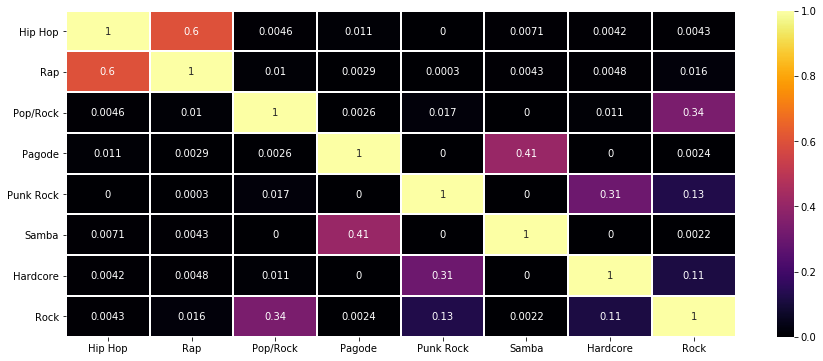

In [136]:

fig, ax = plt.subplots(figsize=(15,6))   
sns.heatmap(df.round(4), cmap = 'inferno', annot=True, linewidth = 1)
plt.show()

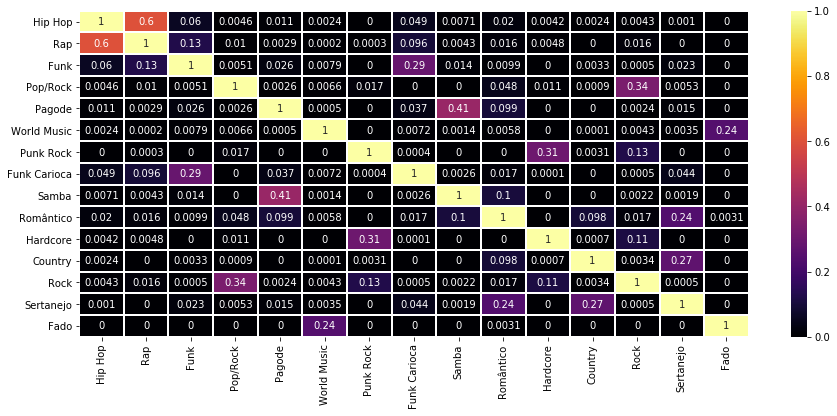

In [133]:

fig, ax = plt.subplots(figsize=(15,6))   
sns.heatmap(df.round(4), cmap = 'inferno', annot=True, linewidth = 1)
plt.show()

In [144]:
def process(genres_arr):
    size = 0
    try:
        size = len(genres_arr)
    finally:
        return size
       
    
df_lyrics["SizeGenres"] = df_lyrics["Genres"].map(process)


In [145]:
df_lyrics["SizeGenres"].value_counts()

3    227228
2     17521
1     14785
Name: SizeGenres, dtype: int64

In [146]:
df_lyrics[df_lyrics["SizeGenres"]==1]

,ALink,SName,SLink,Lyric,ParentGenre,Genres,SizeGenres
310,/laura-helena/,Agora sai,/laura-helena/agora-sai.html,Não queria ter feito o que eu fiz. pois bem. F...,Black Music,[Black Music],1
311,/laura-helena/,Essa sou eu,/laura-helena/essa-sou-eu.html,Eu sempre fui assim. quis me esconder. Com med...,Black Music,[Black Music],1
312,/laura-helena/,Fazer voce acreditar,/laura-helena/fazer-voce-acreditar.html,Agora. é a hora. não tenho nada a perder. mas ...,Black Music,[Black Music],1
313,/laura-helena/,Me Encontrar,/laura-helena/me-encontrar.html,Whoa. Oh. Ooh. . Nesta festa. Sozinha começo a...,Black Music,[Black Music],1
314,/laura-helena/,Nunca Vou Te Esquecer (Dueto),/laura-helena/nunca-vou-te-esquecer.html,Ela:parece que ele não me ajuda. Que ele não m...,Black Music,[Black Music],1
315,/laura-helena/,Pensar Alto,/laura-helena/pensar-alto.html,Olhe para essa noite. De lua cheia. Olhe para ...,Black Music,[Black Music],1
316,/laura-helena/,Se desligue do mundo,/laura-helena/se-desligue-do-mundo.html,Vai lá. respire fundo. e se desligue do mundo....,Black Music,[Black Music],1
317,/laura-helena/,Sozinha,/laura-helena/sozinha.html,Foi íncrivel. foi um sonho sim. Todas as lembr...,Black Music,[Black Music],1
320,/leandro-luther-fumaca/,Estilosa,/leandro-luther-fumaca/estilosa.html,Êta lá em casa!. Lá no meu barraco!. Ia ser um...,Black Music,[Black Music],1
1984,/andre-christovam/,Carne de Pescoço,/andre-christovam/carne-de-pescoco.html,"Em plena rua Aurora, meu carro pifou. Chegando...",Blues,[Blues],1


In [147]:
df = df_lyrics[df_lyrics["SizeGenres"]==1]
df["ParentGenre"].value_counts()

Gospel/Religioso    5557
Sertanejo           2306
Romântico           1016
MPB                  779
Funk Carioca         656
Forró                606
Rap                  522
Pop/Rock             365
Rock                 352
Pop                  342
Samba                302
Reggae               263
World Music          193
Infantil             180
Samba Enredo         173
Bossa Nova           150
Pagode               130
Rock Alternativo     123
Heavy Metal          111
Folk                 104
Punk Rock             95
Trilha Sonora         81
Hip Hop               76
Hardcore              52
Hard Rock             36
Fado                  35
Indie                 31
Regional              22
New Age               17
Kizomba               16
Blues                 15
Dance                 12
Country               10
Electronica            9
Metal                  9
Black Music            9
J-Pop/J-Rock           8
Funk                   6
R&B                    5
Jovem Guarda           3
